In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.ndimage
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import HyperModel, RandomSearch

from spatialinfo import spatial_information as si

ModuleNotFoundError: No module named 'spatialinfo'

In [2]:
%pip install -e ../.

Obtaining file:///D:/projects/SpatialInformation
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for spatialinfo (pyproject.toml): started
  Building editable for spatialinfo (pyproject.toml): finished with status 'done'
  Created wheel for spatialinfo: filename=spatialinfo-0.0.0-0.editable-py3-none-any.whl size=5390 sha256=b71bfa17346140e6441840b9ac73d074c104c53902b6736ba6a7f9caa492809e
  Stored in directory: C:\Users\lukas\AppData\Local\Temp\pip-ephem-wheel-cache-0w1stkrg\wheels\a8\a3\da\60b2de75965afc4c2168f79a3162ef8bb7730

[Introduction](#location-decoding-from-population-activity)



[ANN](#build-and-run-the-model)

# Location Decoding From Population Activity

This notebook extends the analysis of neural activity data (2P calcium imaging) of adult zebrafish moving through a virtual reality (1D corridors). Here, the amount of information encoded in the population activity will be measured. Secondly, the position of the fish within the VR will be decoded from activity data by different statistical procedures. 

1. Mututal information between single neuron activity and location of the animal
2. Logistic classifier for the corridors based on neural activity

Regarding the first point, one approach would be to calculate the information gain for each feature (i.e., activity of each neuron). One could construct the problem at hand as a classification problem, where our input vector is

$X_i = \begin{bmatrix} \lambda_1 \\\ \lambda_2 \\\ \lambda_3 \\\ \lambda_{...} \\\ \lambda_j \end{bmatrix}$, with $\lambda_{1-j}$ being the averaged activity of each neuron for space bin i. The output vector might then take the form of 

$Y_i = \begin{bmatrix} corridor \\\ bin_i \end{bmatrix}$ or $Y_i =  bin_i^{corridor}$

### Input Files
We are using the following data structure: 
```
processed_datasets/
├── yyyymmdd_Area_AcqNr/
│   ├── yyyymmdd_Area_AcqNr_dff.pkl
│   ├── yyyymmdd_Area_AcqNr_behavior.pkl
```

These .pkl files contain activity data for all neurons in a given dataset ($\Delta F/F_0$ normalized) and the position of the fish in the virtual reality (X and Y columns for spatial information and frdIn for tailbeat intensity).


### Pre-processing
Initially, we follow the steps outlined in the notebook on [spatial information coding](SpatialInformationCoding.ipynb). 

1. We discretize the behavioral data into spatial bins tiling the two corridors.
2. We compute the average activity matrix that contains the average activity per neuron per spatial bin.
3. This dataset will be min/max normalized for each neuron.
4. From here, we obtain the input/output pairs with an activity vector of all neurons for a given space bin as the input and the identity of the space bin as the output.





### References

https://www.geeksforgeeks.org/information-gain-and-mutual-information-for-machine-learning/

In [45]:
# functions for loading and pre-processing the data

def load_data(file_path: Path):
    dff = pd.read_pickle(sorted(file_path.glob("*dff.pkl"))[0])
    behavior = pd.read_pickle(sorted(file_path.glob("*behavior.pkl"))[0])
    return dff, behavior

def remove_interpolated_values(behavior, n_corr=2):
    '''
    Cleans up interpolated X values by reassigning them to the nearest valid corridor value in time order.

            Parameters:
                    behavior (pandas.core.frame.DataFrame): contains X, Y columns with spatial information
                    n_corr (int): number of corridors to consider (defaults to 2)

            Returns:
                    behavior (pandas.core.frame.DataFrame): cleaned behavior data with X values reassigned
    '''
    # Get the most common corridor values
    corr_val = behavior['X'].value_counts().head(n_corr).index.values

    # Replace invalid X values with the next valid value in the time sequence
    last_valid_value = None
    for i in range(len(behavior)):
        if behavior.loc[i, 'X'] not in corr_val:
            if last_valid_value is not None:
                behavior.loc[i, 'X'] = last_valid_value
        else:
            last_valid_value = behavior.loc[i, 'X']
    
    return behavior

    
def binning2(dff, behavior, n_bins=10, n_corr=2, fps=30, bin_edges=None):
    """
    Bins occupancy and activity data using predefined bin edges when available.

    Parameters:
        dff (DataFrame): df/f calcium imaging data (rows: time; columns: neurons)
        behavior (DataFrame): Behavioral data with 'X' (corridor) and 'Y' (position)
        n_bins (int): Number of bins, defaults to 10
        n_corr (int): Number of corridors, defaults to 2
        fps (int): Frames per second, defaults to 30
        bin_edges (array-like, optional): Precomputed bin edges for Y-position

    Returns:
        time_per_bin (DataFrame): Time spent in each bin, n_bins x n_corridors
        summed_traces (DataFrame): Summed activity for each bin, n_bins x n_corridors x n_neurons
        y_bin_edges (array): Bin edges used for binning (can be reused for test data)
    """
    if bin_edges is None:
        # Create bin edges from behavioral data
        bin_edges = np.linspace(behavior["Y"].min(), behavior["Y"].max(), n_bins + 1)

    # Assign bins based on predefined bin edges
    behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1

    # Group by corridor and Y-bin, then compute time spent per bin
    time_per_bin = behavior.groupby(["X", "Y_bin"]).size().unstack(fill_value=0).T
    time_per_bin = time_per_bin / fps  # Convert to seconds

    # Sum calcium traces for each bin
    summed_traces = (
        behavior[["X", "Y_bin"]]
        .join(dff, how="left")
        .groupby(["X", "Y_bin"])
        .sum()
        .unstack(level=0, fill_value=0)
    )

    # Ensure binning structure remains consistent
    summed_traces.rename_axis("Space bin", inplace=True)
    summed_traces.columns.set_names(["Neuron", "Corridor"], inplace=True)

    return time_per_bin, summed_traces, bin_edges

def binning(dff, behavior, n_bins = 30, n_corr = 2, fps = 30, bins = None):
    '''
    Bins occupancy and activity data. Assumes that corridors have been completely sampled by the animal. 
    Assumes that distinct corridors are characterized by X position.

            Parameters:
                    dff (pandas.core.frame.DataFrame): df/f calcium imaging data (rows: time; columns: neurons)
                    behavior (pandas.core.frame.DataFrame): contains X, Y columns with spatial information and frdIn with tail vigor
                    n_bins (int): number of bins, defaults to 30 
                    n_corr (int): number of corridors, defaults to 2
                    fps (int): frames per second, defaults to 30
                    bins (numpy.ndarray): edges for bins can optionally be provided

            Returns:
                    time_per_bin (pandas.core.frame.DataFrame): time spent in each bin, n_bins x n_corridors
                    summed_traces (pandas.core.frame.DataFrame): summed activity for each bin, n_bins x n_corridors x n_neurons
                    bins (numpy.ndarray or IntervalIndex): returns the computed bins
    '''
    if bins == None:
        # Create bin labels, cut the Y positions into bins and X into corridor values.
        behavior['Y_bin'], bins = pd.cut(behavior['Y'], bins=n_bins, labels=False, retbins=True)        
    else:
        behavior['Y_bin'] = pd.cut(behavior['Y'], bins=bins, labels=False)
    behavior['X_bin'] = pd.cut(behavior['X'], bins = len(behavior.X.unique()))
    
    # Group by the corridor ID (X position) and Y-bin, and calculate the time per bin
    time_per_bin = behavior.groupby(['X_bin', 'Y_bin'], observed=False).size().unstack(fill_value=0)
    
    # Automatically generate column names based on the number of corridors
    num_corridors = time_per_bin.shape[0]
    column_names = [f"Corridor_{i+1}" for i in range(num_corridors)]
    time_per_bin = pd.DataFrame(time_per_bin.T.values, columns=column_names) / fps
    
    # Sum calcium traces for each bin and corridor
    summed_traces = (
        behavior[['X', 'Y_bin']]
        .join(dff, how='left')
        .groupby(['X', 'Y_bin'])
        .sum()
        .unstack(level=0, fill_value=0)
    )
    
    # Make column and row names intuitive:
    summed_traces.rename_axis("Space bin", inplace=True)
    summed_traces.columns.set_names(["Neuron", "Corridor"], inplace=True)
    #summed_traces.convert_dtypes().dtypes # hard conversion
    summed_traces.apply(pd.to_numeric).dtypes
    
    return time_per_bin, summed_traces, bins
    
def avg_activity(time_per_bin, summed_traces):
    '''
    Devides summed neural activity matrix by the occupancy matrix to obtain the average activity in each spatial bin.
    
            Parameters:
                    time_per_bin (pandas.core_frame.DataFrame): time spent in each bin, n_bins x n_corridors
                    summed_traces (pandas.core.frame.DataFrame): summed activity for each bin, n_bins x n_corridors x n_neurons
            Returns:
                    avg_activity_mtx (pandas.core_frame.DataFrame): average activity in each spatial bin.
    '''
    # Create an empty DataFrame with the same structure as summed_traces
    avg_activity_mtx = pd.DataFrame(index=summed_traces.index, columns=summed_traces.columns)

    # Iterate through each neuron column group (level 1 in the MultiIndex)
    for neuron in summed_traces.columns.get_level_values("Neuron").unique():
        trace = summed_traces[neuron].apply(pd.to_numeric)
        # Apply the division by the time occupancy for each neuron and assign to the new DataFrame
        avg_activity_mtx[neuron] = (
            trace.div(time_per_bin.values, axis=0)
        )
    
    return avg_activity_mtx

def add_trial_column(behavior):
    '''
    Adds a "trial" column to the behavior DataFrame based on Y-position resets (teleports).
    
    Parameters:
        behavior (DataFrame): Behavioral data containing the Y column (position).
    
    Returns:
        behavior (DataFrame): Updated DataFrame with a new "trial" column.
    '''
    # Initialize the trial counter and create an empty list for trial numbers
    trial_counter = 0
    trial_numbers = []

    # Iterate through the Y-position data
    for i in range(len(behavior)):
        # Check if the current Y position is 0 and the previous Y position was non-zero
        if i > 0 and behavior.loc[i, 'Y'] == 0 and behavior.loc[i - 1, 'Y'] != 0:
            # Increment the trial counter
            trial_counter += 1

        # Assign the current trial number
        trial_numbers.append(trial_counter)

    # Add the trial column to the DataFrame
    behavior['trial'] = trial_numbers

    return behavior

def add_trial_column(behavior):
    """
    Adds a 'trial' column to the behavior DataFrame.
    
    A trial starts when:
    1. The animal moves backward (Y-position decreases by being teleported to starting position).
    2. The corridor changes (X-position changes).

    Parameters:
        behavior (DataFrame): Must contain 'X' (corridor) and 'Y' (position in corridor).

    Returns:
        behavior (DataFrame): Updated DataFrame with a new 'trial' column.
    """
    trial_counter = 0
    trial_numbers = [0]  # First trial is always 0

    # Iterate through the behavior data (starting from index 1)
    for i in range(1, len(behavior)):
        # Get change in Y and change in X
        y_diff = behavior.loc[i, "Y"] - behavior.loc[i - 1, "Y"]
        x_diff = behavior.loc[i, "X"] - behavior.loc[i - 1, "X"]

        # Check if a new trial should start
        if y_diff < -1 or x_diff != 0: # -1 protects against positional jitter
            trial_counter += 1  # Increment trial counter

        # Append the trial number for the current row
        trial_numbers.append(trial_counter)

    # Assign trial numbers to the DataFrame
    behavior["trial"] = trial_numbers

    return behavior


def trials_over_time(dff, behavior, n_bins=30):
    """
    Returns a multi-index DataFrame containing the average activity per spatial bin 
    per corridor per trial for each neuron.

    Parameters:
        dff (DataFrame): dF/F activity data in timepoints (rows) x neurons (columns).
        behavior (DataFrame): Behavioral data in timepoints (rows) x behavior (column).
        n_bins (int): Number of spatial bins to divide the Y-position.

    Returns:
        DataFrame: Multi-index DataFrame with (neuron, trial, corridor, Y_bin) as indices.
    """

    # Step 1: Extract metadata
    n_neurons = dff.shape[1]
    
    # Step 2: Create spatial bins for Y-position
    behavior['Y_bin'] = pd.cut(behavior['Y'], bins=n_bins, labels=False)

    # Step 3: Identify unique trials and corridors
    trials = behavior['trial'].unique()
    corridors = behavior['X'].unique()

    # Step 4: Initialize storage for results
    results = []

    # Step 5: Iterate over neurons, trials, and corridors
    for neuron in range(n_neurons):
        neuron_activity = dff.iloc[:, neuron]  # Select the neuron

        for trial in trials:
            trial_data = behavior[behavior['trial'] == trial]
            trial_activity = neuron_activity.loc[trial_data.index]  # Activity for this trial
            
            for corridor in corridors:
                corridor_data = trial_data[trial_data['X'] == corridor]
                corridor_activity = trial_activity.loc[corridor_data.index]

                # Compute average activity per spatial bin
                avg_activity_per_bin = corridor_activity.groupby(corridor_data['Y_bin']).mean()

                # Ensure all bins are represented (fill missing bins with NaN)
                avg_activity_per_bin = avg_activity_per_bin.reindex(range(n_bins), fill_value=np.nan)

                # Store results
                for y_bin, activity in avg_activity_per_bin.items():
                    results.append([neuron, trial, corridor, y_bin, activity])

    # Step 6: Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=['neuron', 'trial', 'corridor', 'Y_bin', 'activity'])

    # Step 7: Pivot to create a multi-dimensional DataFrame
    # results_df = results_df.pivot_table(index=['neuron', 'trial', 'corridor'], columns='Y_bin', values='activity')
    results_df = results_df.pivot_table(index=['neuron', 'trial', 'corridor', 'Y_bin'], values='activity')

    # Step 8: Normalize activity per neuron (Min/Max scaling across all bins and trials)
    # scaler = MinMaxScaler()
    # results_df[:] = scaler.fit_transform(results_df) # scale later
    return results_df

def format_for_ann(df):
    """
    Converts the multi-index DataFrame into input-output format for training a neural network.
    
    Ensures that each row represents one spatial bin (with trial & corridor info),
    and columns represent neuronal activity.

    Parameters:
        df (DataFrame): Multi-index DataFrame with (neuron, trial, corridor, Y_bin) indices.

    Returns:
        X (ndarray): Feature matrix where each row is a neuronal activity vector (neurons as columns).
        y (tuple): Tuple of target labels (bins, corridors).
    """
    # Reset index so we can manipulate it
    df = df.reset_index()

    # Pivot so that each row represents a (trial, corridor, bin), and each column is a neuron
    reshaped_df = df.pivot_table(index=['trial', 'corridor', 'Y_bin'], columns='neuron', values='activity')

    # Drop any remaining NaNs (bins with missing neuron activity)
    reshaped_df = reshaped_df.dropna()

    # Extract the final feature matrix
    X = reshaped_df.values  # Now, shape (n_samples, n_neurons)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Extract labels
    y_bins = reshaped_df.index.get_level_values('Y_bin').values  # Bin labels
    y_corridors = reshaped_df.index.get_level_values('corridor').values  # Corridor labels

    # Map corridor labels to categorical values (0 and 1)
    unique_corridors = sorted(np.unique(y_corridors))
    corridor_mapping = {unique_corridors[0]: 0, unique_corridors[1]: 1}
    y_corridors = np.array([corridor_mapping[c] for c in y_corridors])

    return X, (y_bins, y_corridors)

We first load the data, add the trial column to the behavior dataset and compute the multi-index dataframe. Then, we build input and output vectors.

In [3]:
dff, bh = load_data(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = remove_interpolated_values(bh, n_corr=2)
bh = add_trial_column(bh)
results_df = trials_over_time(dff, bh, n_bins=30) # 30

X, (y_bins, y_corridors) = format_for_ann(results_df)

Classically, the data is split in train and test set: 

In [4]:
# Split the data
X_train, X_test, y_bins_train, y_bins_test, y_corridors_train, y_corridors_test = train_test_split(
    X, y_bins, y_corridors, test_size=0.1, random_state=42, stratify=y_bins  # Stratify by bins
)

# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_bins_train shape:", y_bins_train.shape)
print("y_bins_test shape:", y_bins_test.shape)
print("y_corridors_train shape:", y_corridors_train.shape)
print("y_corridors_test shape:", y_corridors_test.shape)

# Check class balance
corridor_counts = pd.Series(y_corridors).value_counts()
print("Corridor Distribution:\n", corridor_counts)

# Check bin distribution
bin_counts = pd.Series(y_bins).value_counts()
print("Bin Distribution:\n", bin_counts)

X_train shape: (656, 366)
X_test shape: (73, 366)
y_bins_train shape: (656,)
y_bins_test shape: (73,)
y_corridors_train shape: (656,)
y_corridors_test shape: (73,)
Corridor Distribution:
 1    380
0    349
Name: count, dtype: int64
Bin Distribution:
 1     34
0     34
2     32
3     31
5     29
4     29
6     28
7     26
12    24
13    24
10    23
9     23
8     23
11    23
24    23
23    23
22    23
21    23
20    23
19    23
18    23
17    23
16    23
15    23
14    23
25    20
26    19
28    18
29    18
27    18
Name: count, dtype: int64


## Build and run the model

In [5]:
def build_keras_model(input_size, n_bins, n_corridors):
    inputs = tf.keras.Input(shape=(input_size,))
    
    # Shared layers
    x = layers.Dense(128, activation="relu")(inputs) # 128
    x = layers.Dense(64, activation="relu")(x) # 64
    

    # Two separate outputs
    bin_output = layers.Dense(n_bins, activation="softmax", name="bin_output")(x)
    corridor_output = layers.Dense(n_corridors, activation="softmax", name="corridor_output")(x)

    model = models.Model(inputs=inputs, outputs=[bin_output, corridor_output])
    
    model.compile(optimizer="adam",
                  loss={"bin_output": "sparse_categorical_crossentropy",
                        "corridor_output": "sparse_categorical_crossentropy"},
                  metrics={"bin_output": ["accuracy"],
                           "corridor_output": ["accuracy"]})  # Fix: Separate metrics
    
    return model

# Build and train the model
keras_model = build_keras_model(input_size=X.shape[1], n_bins=30, n_corridors=2)
keras_model.fit(X_train, {"bin_output": y_bins_train, "corridor_output": y_corridors_train}, epochs=200, batch_size=64)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - bin_output_accuracy: 0.0298 - bin_output_loss: 3.5326 - corridor_output_accuracy: 0.4985 - corridor_output_loss: 0.7635 - loss: 4.2971
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.0531 - bin_output_loss: 3.3981 - corridor_output_accuracy: 0.5094 - corridor_output_loss: 0.6871 - loss: 4.0834 
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.0360 - bin_output_loss: 3.3974 - corridor_output_accuracy: 0.5709 - corridor_output_loss: 0.6673 - loss: 4.0649 
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.0472 - bin_output_loss: 3.3959 - corridor_output_accuracy: 0.7858 - corridor_output_loss: 0.6373 - loss: 4.0331 
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.0509 - bin_output_loss: 3.3776 - corridor_output_accuracy: 0.8588 - corridor_output_loss: 0.6154 - loss: 3.9934 
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.3847 - bin_output_loss: 1.7799 - corridor_output_accuracy: 0.9740 - corridor_output_loss: 0.0699 - loss: 1.8508 
Epoch 74/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.3812 - bin_output_loss: 1.7938 - corridor_output_accuracy: 0.9803 - corridor_output_loss: 0.0607 - loss: 1.8532 
Epoch 75/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.4380 - bin_output_loss: 1.7893 - corridor_output_accuracy: 0.9613 - corridor_output_loss: 0.0995 - loss: 1.8898 
Epoch 76/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - bin_output_accuracy: 0.4231 - bin_output_loss: 1.7358 - corridor_output_accuracy: 0.9907 - corridor_output_loss: 0.0593 - loss: 1.7932 
Epoch 77/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.3831 - bin_output_loss: 1.7503 - corridor_output_accuracy: 0.9795 - corridor_output_loss: 0.0698 - loss: 1.8238 
Epoch 78/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_outpu

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.5468 - bin_output_loss: 1.2373 - corridor_output_accuracy: 0.9882 - corridor_output_loss: 0.0307 - loss: 1.2702 
Epoch 146/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.5862 - bin_output_loss: 1.2034 - corridor_output_accuracy: 0.9902 - corridor_output_loss: 0.0377 - loss: 1.2431 
Epoch 147/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.5734 - bin_output_loss: 1.2057 - corridor_output_accuracy: 0.9914 - corridor_output_loss: 0.0290 - loss: 1.2386 
Epoch 148/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.5710 - bin_output_loss: 1.2236 - corridor_output_accuracy: 0.9953 - corridor_output_loss: 0.0291 - loss: 1.2552 
Epoch 149/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_output_accuracy: 0.5833 - bin_output_loss: 1.2008 - corridor_output_accuracy: 0.9900 - corridor_output_loss: 0.0326 - loss: 1.2322 
Epoch 150/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_

In [58]:
# Get model predictions on the test set
y_pred_bins, y_pred_corridors = keras_model.predict(X_test)

# Convert probabilities to class labels
y_pred_bins = np.argmax(y_pred_bins, axis=1)  # Get the highest probability bin
y_pred_corridors = np.argmax(y_pred_corridors, axis=1)  # Get highest probability corridor


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [59]:
# Compute accuracy
bin_accuracy = accuracy_score(y_bins_test, y_pred_bins)
corridor_accuracy = accuracy_score(y_corridors_test, y_pred_corridors)

print(f"Bin Classification Accuracy: {bin_accuracy:.4f}")
print(f"Corridor Classification Accuracy: {corridor_accuracy:.4f}")


Bin Classification Accuracy: 0.4082
Corridor Classification Accuracy: 0.8980


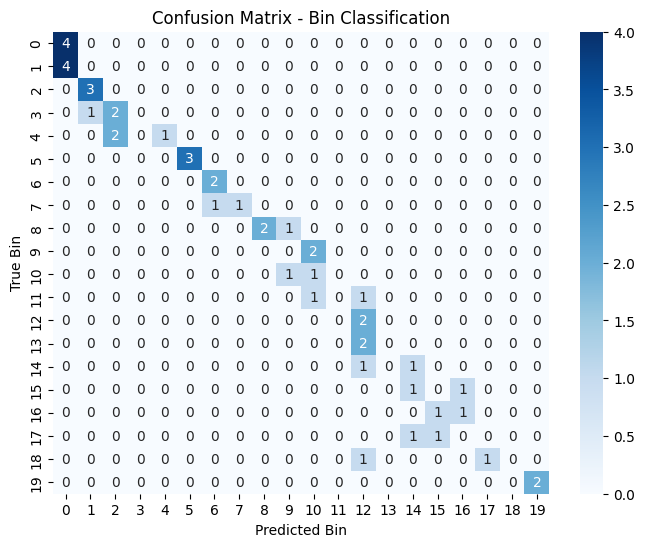

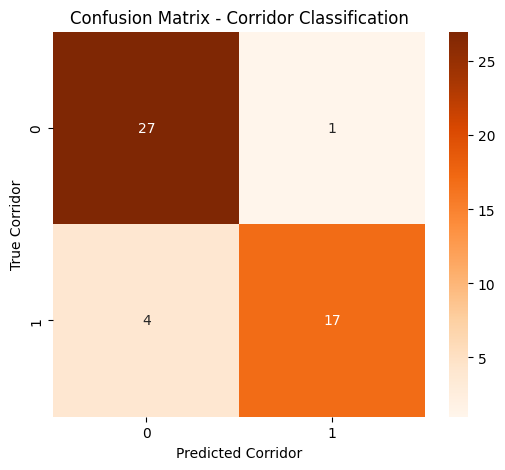

In [60]:
# Bin classification confusion matrix
conf_matrix_bins = confusion_matrix(y_bins_test, y_pred_bins)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bins, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_bins_test), yticklabels=np.unique(y_bins_test))
plt.xlabel("Predicted Bin")
plt.ylabel("True Bin")
plt.title("Confusion Matrix - Bin Classification")
plt.show()

# Corridor classification confusion matrix
conf_matrix_corridors = confusion_matrix(y_corridors_test, y_pred_corridors)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_corridors, annot=True, fmt="d", cmap="Oranges", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Corridor")
plt.ylabel("True Corridor")
plt.title("Confusion Matrix - Corridor Classification")
plt.show()

In [61]:
# Print classification reports
print("Classification Report - Bin Classification:")
print(classification_report(y_bins_test, y_pred_bins))

print("Classification Report - Corridor Classification:")
print(classification_report(y_corridors_test, y_pred_corridors))

Classification Report - Bin Classification:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       1.00      0.50      0.67         2
           8       1.00      0.67      0.80         3
           9       0.00      0.00      0.00         2
          10       0.25      0.50      0.33         2
          11       0.00      0.00      0.00         2
          12       0.29      1.00      0.44         2
          13       0.00      0.00      0.00         2
          14       0.33      0.50      0.40         2
          15       0.00      0.00      0.00         2
          16       0.50      0.50    

C:\Users\anneluka\.conda\envs\NeuronVisionVenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anneluka\.conda\envs\NeuronVisionVenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anneluka\.conda\envs\NeuronVisionVenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [62]:
def proximity_weighted_accuracy(y_true, y_pred, max_distance=2):
    """
    Compute accuracy where predictions closer to the true bin get partial credit.

    Parameters:
        y_true (array-like): True bin labels.
        y_pred (array-like): Predicted bin labels.
        max_distance (int): Maximum distance for partial credit.

    Returns:
        float: Proximity-weighted accuracy score.
    """
    total_score = 0
    for true, pred in zip(y_true, y_pred):
        distance = abs(true - pred)
        if distance <= max_distance:
            total_score += 1 - (distance / (max_distance + 1))
    
    return total_score / len(y_true)

# Evaluate proximity-weighted accuracy
proximity_acc = proximity_weighted_accuracy(y_bins_test, y_pred_bins)
print(f"Proximity-Weighted Accuracy: {proximity_acc:.4f}")

Proximity-Weighted Accuracy: 0.7415


It would be interesting to deduce how much information individual features (=neurons) contribute in the classification task. To compute these values, I combine bin and corridor in a joint score:

In [10]:
y_combined = y_bins + y_corridors * (max(y_bins) + 1)

6


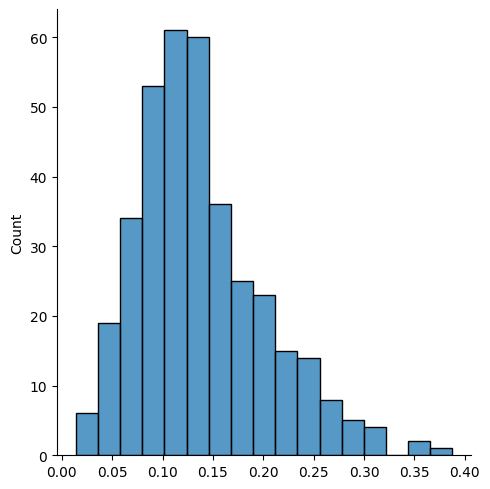

In [14]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Calculate Mutual Information using mutual_info_regression
mutual_info = mutual_info_regression(X, y_combined)
sns.displot(mutual_info)

print(np.argmax(mutual_info))

In [32]:
mutual_info[318]

np.sum(mutual_info>0.23)/len(mutual_info)

0.10655737704918032

Another aspect to look at is the _information gain_ we receive when we include any given feature in the classification task. 

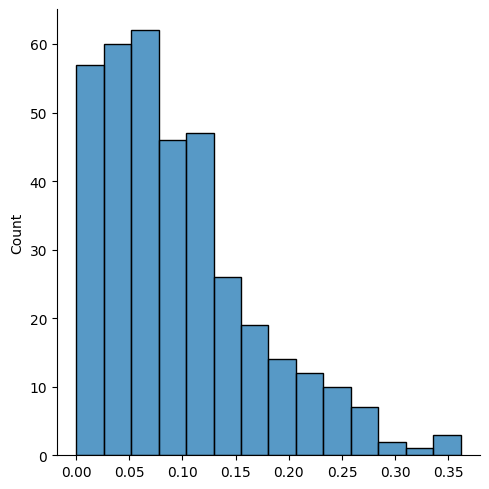

In [22]:

# Calculate Information Gain using mutual_info_classif
info_gain = mutual_info_classif(X, y_combined)
sns.displot(info_gain)

In [30]:
np.sum(info_gain>0.2)/len(info_gain)

0.10382513661202186

## Direct Basis Decoder

The ANN above is not the gold standard for position decoding in the spatial navigation field. For example, in the [Yang et al. paper from 2024](https://www.nature.com/articles/s41586-024-07867-2), the authors used a direct basis decoder as described below (quoted from their M&M section):

"*The direct basis decoder is a linear decoder with no free parameters that predicts the animal’s position at each individual time point by a linear combination of the spatial activity maps, weighted with the activity of the corresponding place-encoding cell. All decoding and map construction was performed only at those timepoints at which the fish was moving (fish speed greater than $0.1 mm*s^{−1}$). Even though no parameters had to be learned, it is still necessary to compute the spatial activity map of each cell. To avoid circularity between computing the spatial activity map and testing the decoder we used a cross-validation scheme in which the neural data were divided into non-overlapping 1 min chunks. To test the decoder on each 1 min chunk we first computed the spatial activity map without including the test chunk or its two neighbouring chunks. The predictions of all 1 min chunks were concatenated as the prediction of the whole dataset. Decoder error was then computed as the mean distance between the predicted and actual position of the fish across the dataset. Spatial activity maps were constructed as described above using spatial bins (side length 1.2 mm) and boundary-constrained Gaussian smoothing. Apart from the analysis shown in Extended Data Fig. 5c, the activity used in this map construction is time shifted by 2 s relative to the location of the fish, to counteract potential calcium lag dynam-ics. All maps were standardized by mean and standard deviation. To prepare the decoder, a 7.5 s boxcar average filter was applied to the activity and then maps of the most active 30% of cells were weighted by their respective activity and summed to form the decoder map.*"

This method was originally introduced by [Zhang et al., 1998](https://journals.physiology.org/doi/full/10.1152/jn.1998.79.2.1017). 

According to their description, basis function methods rely on the linear combination of basis functions (or fixed templates), with the coefficients in the linear combination being proportional to the activity of the neuron at the time point in question. 

$$
\displaystyle\sum_{i} n_{i} * \phi_{i}(x)
$$
is the distribution over physical space, indexed by x. The peak value of this distribution is taken as the reconstructed position 
$$
\hat{x} = \arg\max_{x} \sum_{i} n_{i} * \phi_{i}(x)
$$

To create the fixed templates, the above defined functions will be used:
- binning()
- avg_activity()


Additionally, 
- add regression
- create sliding window function to cross-validate

In [40]:
# load data, pre-process, construct activity matrices
dff, bh = load_data(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = remove_interpolated_values(bh, n_corr=2)
bh = add_trial_column(bh)
time_per_bin, summed_traces, _ = binning(dff, bh, n_bins=30)
avg_act_mtx = avg_activity(time_per_bin, summed_traces)

ValueError: Unable to coerce to DataFrame, shape must be (31, 2): given (2, 31)

In [44]:
time_per_bin.T

X,-0.0,50.5
Y_bin,,
0,101.133333,246.733333
1,18.633333,111.233333
2,17.500000,82.500000
3,16.000000,76.733333
4,16.066667,9.333333
5,9.200000,77.333333
6,13.600000,123.100000
7,6.866667,203.033333
8,9.466667,11.066667


In [48]:
def fixed_template(dff, behavior, n_corridors=2, n_bins=30):
    """
    Implements direct basis decoding with LOOCV using fixed binning.

    Parameters:
        dff (DataFrame): Calcium imaging traces for all neurons.
        behavior (DataFrame): Behavioral data with X (corridor), Y (position).
        n_corridors (int): Number of corridors in the setting (default=2).
        n_bins (int): Number of spatial bins (default=30).

    Returns:
        decoded_position (DataFrame): Decoded X and Y positions.
    """
    # Preprocess behavior data
    bh = remove_interpolated_values(behavior, n_corr=n_corridors)
    if "trial" not in bh.columns:
        bh = add_trial_column(bh)

    # Initialize storage for decoded results
    decoded_positions = []

    # Perform Leave-One-Out Cross-Validation (LOOCV)
    for trial in bh["trial"].unique():
        print(f"Performing LOOCV on trial {trial}.")

        # Split data into training and test sets
        dff_test = dff[bh["trial"] == trial]
        dff_train = dff[bh["trial"] != trial]
        bh_test = bh[bh["trial"] == trial]
        bh_train = bh[bh["trial"] != trial]

        # Compute binning for training data
        time_per_bin, summed_traces, bins = binning(dff_train, bh_train, n_bins=n_bins)

        # Compute average activity templates (fixed decoder)
        avg_act_mtx = avg_activity(time_per_bin, summed_traces)

        # Apply the same binning to test data
        time_per_bin, summed_traces, _ = binning(dff_test, bh_test, n_bins=n_bins, bins=bins)
        loocv_bins = avg_activity(time_per_bin, summed_traces)
        
        # Get the single corridor value for this trial
        corridor = bh_test["X"].iloc[0]

        # Loop through each space bin in the test trial
        for space_bin in range(n_bins):
            if space_bin not in loocv_bins.index:
                continue  # Skip if test data does not contain this bin

            # Extract the population vector for this bin
            pop_vector = loocv_bins.xs(key=corridor, level="Corridor", axis=1).loc[space_bin]

            # Compute weighted activity map
            scaled_matrix = avg_act_mtx.xs(key=corridor, level="Corridor", axis=1).mul(pop_vector, axis=1)

            # Decode by summing across neurons
            decoded_map = scaled_matrix.sum(axis=1)

            # Store results
            decoded_positions.append({
                "trial": trial,
                "corridor": corridor,
                "true_bin": space_bin,
                "decoded_bin": decoded_map.idxmax()  # Pick the most active decoded bin
            })

    return pd.DataFrame(decoded_positions)
            
        
  
        

        
        
    

In [49]:
fixed_template(dff, bh)

Performing LOOCV on trial 0.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 1.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 2.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 3.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 4.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 5.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 6.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 7.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 8.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 9.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 10.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 11.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 12.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 13.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 14.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 15.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 16.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 17.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 18.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 19.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 20.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 21.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 22.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 23.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 24.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 25.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 26.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 27.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 28.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 29.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 30.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 31.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 32.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 33.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 34.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 35.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 36.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 37.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 38.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 39.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 40.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 41.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 42.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 43.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 44.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 45.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 46.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 47.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 48.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 49.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 50.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 51.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 52.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 53.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 54.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 55.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 56.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 57.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 58.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 59.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 60.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 61.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 62.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 63.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 64.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 65.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 66.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


Performing LOOCV on trial 67.


C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1
C:\Users\anneluka\AppData\Local\Temp\ipykernel_12636\2591708009.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior["Y_bin"] = np.digitize(behavior["Y"], bins=bin_edges, right=False) - 1


,trial,corridor,true_bin,decoded_bin
0,0,-0.0,12,11
1,0,-0.0,13,4
2,0,-0.0,14,4
3,0,-0.0,15,4
4,0,-0.0,16,4
...,...,...,...,...
903,67,0.0,20,7
904,67,0.0,21,7
905,67,0.0,22,7
906,67,0.0,23,7


In [33]:
print(f"Performing LOOCV on trial {trial}.")

# Split data into training and test sets
dff_test = dff[bh["trial"] == trial]
dff_train = dff[bh["trial"] != trial]
bh_test = bh[bh["trial"] == trial]
bh_train = bh[bh["trial"] != trial]

Performing LOOCV on trial 0.


In [37]:
bh_test

,X,Y,frdIn,trial,Y_bin,X_bin
0,-0.0,63.543000,0.029000,0,12,"(-0.0505, 25.25]"
1,0.0,63.569000,0.026000,0,12,"(-0.0505, 25.25]"
2,0.0,63.580500,0.024500,0,12,"(-0.0505, 25.25]"
3,0.0,63.632001,0.019000,0,12,"(-0.0505, 25.25]"
4,0.0,63.664009,0.015008,0,12,"(-0.0505, 25.25]"
...,...,...,...,...,...,...
348,0.0,150.102000,0.309807,0,29,"(-0.0505, 25.25]"
349,0.0,150.102000,0.250844,0,29,"(-0.0505, 25.25]"
350,0.0,150.102000,0.202875,0,29,"(-0.0505, 25.25]"
351,0.0,150.102000,0.182881,0,29,"(-0.0505, 25.25]"


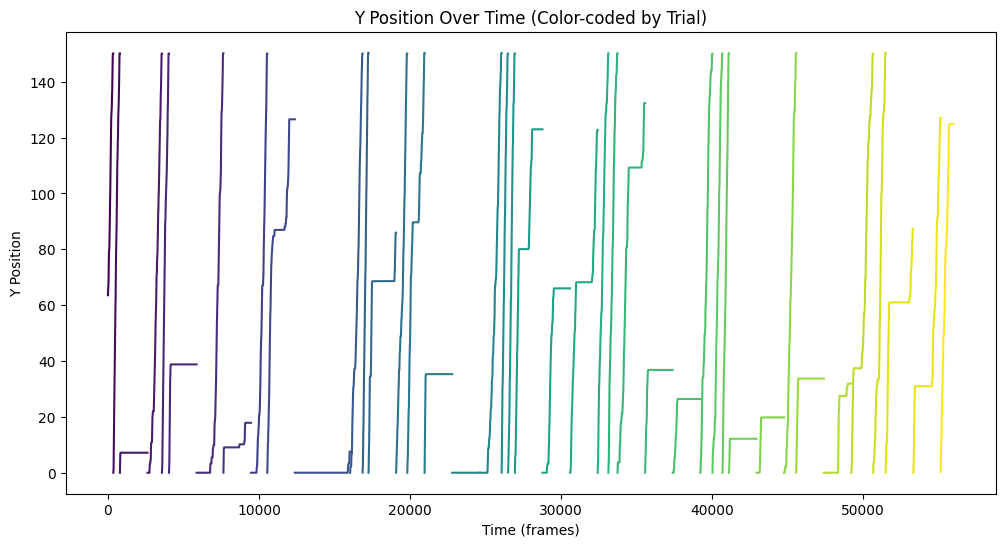

In [25]:
def plot_trials(behavior):
    """
    Plots the Y position over time, color-coded by trial.

    Parameters:
        behavior (DataFrame): Must contain 'Y' (position in corridor) and 'trial' columns.
    """
    plt.figure(figsize=(12, 6))

    # Get unique trials and generate a color map
    unique_trials = behavior["trial"].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_trials)))

    # Plot Y positions, color-coded by trial
    for trial, color in zip(unique_trials, colors):
        trial_mask = behavior["trial"] == trial
        plt.plot(behavior.index[trial_mask], behavior["Y"][trial_mask], color=color, label=f"Trial {trial}")

    plt.xlabel("Time (frames)")
    plt.ylabel("Y Position")
    plt.title("Y Position Over Time (Color-coded by Trial)")
    #plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
    plt.show()
    
plot_trials(bh)

In [95]:
time_per_bin, summed_traces = binning(dff_test, bh_test, n_bins=30) # overwrite with test data
loocv_bins = avg_activity(time_per_bin, summed_traces) # test data to be decode

C:\Users\anneluka\AppData\Local\Temp\ipykernel_5412\4161924360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['Y_bin'] = pd.cut(behavior['Y'], bins=n_bins, labels=False)
C:\Users\anneluka\AppData\Local\Temp\ipykernel_5412\4161924360.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior['X_bin'] = pd.cut(behavior['X'], bins = len(behavior.X.unique()))


In [100]:
bh_test

,X,Y,frdIn,trial,Y_bin,X_bin
0,-0.0,63.543000,0.029000,0,0,"(-0.001, 0.001]"
1,0.0,63.569000,0.026000,0,0,"(-0.001, 0.001]"
2,0.0,63.580500,0.024500,0,0,"(-0.001, 0.001]"
3,0.0,63.632001,0.019000,0,0,"(-0.001, 0.001]"
4,0.0,63.664009,0.015008,0,0,"(-0.001, 0.001]"
...,...,...,...,...,...,...
349,0.0,150.102000,0.250844,0,29,"(-0.001, 0.001]"
350,0.0,150.102000,0.202875,0,29,"(-0.001, 0.001]"
351,0.0,150.102000,0.182881,0,29,"(-0.001, 0.001]"
352,0.0,150.102000,0.132918,0,29,"(-0.001, 0.001]"


In [79]:
avg_act_mtx.xs(key=-0.0, level="Corridor", axis=1).loc[5]

Neuron
0      1.022877
1      3.329449
2      1.328215
3      1.238314
4      0.879347
         ...   
361    0.755248
362    0.911923
363    1.115957
364    1.692393
365    1.224998
Name: 5, Length: 366, dtype: float64

In [13]:
import pandas as pd
import numpy as np
df = pd.DataFrame({"X": np.linspace(0,150,100),
                  "Y": np.linspace(0,150,100)})
out, bins = pd.cut(df.X, bins=30, retbins=True)

In [16]:
df2 = pd.DataFrame({"Z": np.linspace(0,150,100)})
pd.cut(df2.Z, bins)

0       (-0.15, 5.0]
1       (-0.15, 5.0]
2       (-0.15, 5.0]
3       (-0.15, 5.0]
4        (5.0, 10.0]
           ...      
95    (140.0, 145.0]
96    (145.0, 150.0]
97    (145.0, 150.0]
98    (145.0, 150.0]
99    (145.0, 150.0]
Name: Z, Length: 100, dtype: category
Categories (30, interval[float64, right]): [(-0.15, 5.0] < (5.0, 10.0] < (10.0, 15.0] < (15.0, 20.0] ... (130.0, 135.0] < (135.0, 140.0] < (140.0, 145.0] < (145.0, 150.0]]